In [1]:
# Authors: Robert McGibbon, Joel Nothman

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

In [2]:
train = '../data/numerai_training_data.csv'
df = pd.read_csv(train)
data = df[['feature' + str(i) for i in range(1,22)]]
target = df['target']

In [3]:
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=2, param_grid=param_grid)

In [4]:
grid.fit(data, target)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'reduce_dim__n_components': [2, 4, 8], 'reduce_dim': [PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=None, nls_max_iter=2000, random... [SelectKBest(k=10, score_func=<function chi2 at 0x0000023AD4C16158>)], 'reduce_dim__k': [2, 4, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

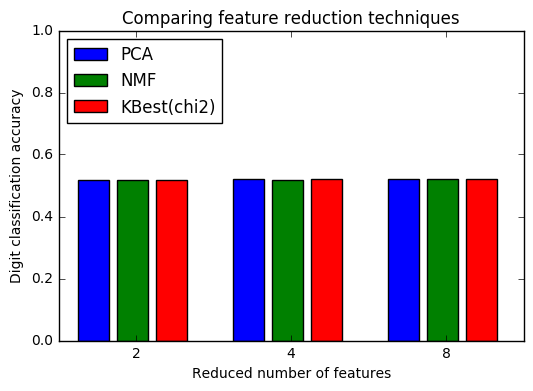

In [5]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()